# DGA detection model

## Table of Contents
* Introduction
* Dataset
* Data Preprocessing
* Binary Model Training and Evaluation
* Familieis Model Training and Evaluation
* Conclusions
* References

## Introduction

Domain generation algorithms (DGA) are algorithms seen in various families of malware that are used to periodically generate a large number of domain names that can be used as rendezvous points with their command and control servers. The large number of potential rendezvous points makes it difficult for law enforcement to effectively shut down botnets, since infected computers will attempt to contact some of these domain names every day to receive updates or commands. The use of public-key cryptography in malware code makes it unfeasible for law enforcement and other actors to mimic commands from the malware controllers as some worms will automatically reject any updates not signed by the malware controllers.

## Dataset

We gathered 3M domains from popular datasets of DGAs.
i.e. https://data.netlab.360.com/dga/

# Imports installation

In [ ]:
# Install required dependencies
! pip install tldextract
! pip install tensorflow
! pip install dgaintel
! pip install torch
! pip install swifter

## Imports

In [ ]:
# Import dependencies
import torch
from torch.utils.data import TensorDataset, DataLoader

import pandas as pd

import numpy as np

import tldextract

import glob

from dgaintel import get_prob

import swifter

import matplotlib.pyplot as pyplot

from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import random
import torch.optim as optim
from tqdm.notebook import tqdm

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tldextract

import swifter

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

import glob

from dgaintel import get_prob

import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM

from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers, regularizers 
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K

## Constants

In [ ]:
# Binary model params
EPOCHS = 30
BATCH_SIZE = 1000
MALICIOUS_RATIO = 0.01
LEARNING_RATE = 0.001
# Families model params
TRAIN_BATCH_SIZE = 500
TEST_BATCH_SIZE = 500
EMB_SIZE = 10
EPOCHS_SIAMESE = 120
LEARNING_RATE_SIAMESE = 1e-3
CLASS_WEIGHTS = {0: 100, 1:1}

## Functions

In [ ]:
# Return URL domain
def get_domain(url):
    domain = tldextract.extract(url).domain
    if domain == 'ddns':
        print(url)
        urls = url.split('.')
        urls_i = urls.index('ddns')
        if urls_i == 0:
            return 'ddns'
        print(urls[urls_i-1])
        return urls[urls_i-1]
    if domain:
        return domain
    return ''
# Make spaces for character processing
def get_domain_space(domain):
    try:
        return " ".join(domain)
    except:
        print(domain)
        return ""
# Split train-test - we are trying change the ratio for small DGA families to test them too 
def split_train_test_dga(df,ratio=0.8):
    df_dga = df[df['label']==1]
    df_legit = df[df['label']==0]
    X_dga, y_dga = df_dga['domain_1'],df_dga['label']
    X_legit, y_legit = df_legit['domain_1'],df_legit['label']
    train_dga_i = []
    train_ben_i = []
    test_dga_i = []
    test_ben_i = []
    # Make the dga train set to be more equale between families without dominant family
    for fam in pd.unique(df_dga['type']):
        df_dga_fam = df_dga[df_dga['type']==fam]
        # Shuffle the dataframe rows
        df_dga_fam = df_dga_fam.sample(frac = 1)
        if len(df_dga_fam)>10000:
            train_dga_i.extend(df_dga_fam.iloc[0:int(ratio*10000)].index)
            test_dga_i.extend(df_dga_fam.iloc[int(ratio*10000):].index)
        else:
            train_dga_i.extend(df_dga_fam.iloc[0:int(ratio*len(df_dga_fam))].index)
            test_dga_i.extend(df_dga_fam.iloc[int(ratio*len(df_dga_fam)):].index)
    df_legit = df_legit.sample(frac = 1)
    train_ben_i.extend(df_legit.iloc[0:int(ratio*len(df_legit))].index)
    test_ben_i.extend(df_legit.iloc[int(ratio*len(df_legit)):].index)
    train_dga_i.extend(train_ben_i)
    test_dga_i.extend(test_ben_i)
    X_train = df['domain_1'][train_dga_i]
    y_train = df['label'][train_dga_i]
    X_test = df['domain_1'][test_dga_i]
    y_test = df['label'][test_dga_i]
    
    return X_train, X_test, y_train, y_test
# Create data loader for the neural-net
def create_data_loader(data,label):
    tensor_data = torch.Tensor(data.astype(int))
    tensor_label = torch.Tensor(label)
    my_dataset = TensorDataset(tensor_data,tensor_label)
    data_loader = DataLoader(my_dataset, batch_size=BATCH_SIZE, shuffle=True)
    return data_loader
# Create batches for Siamese networks
def create_batch_offline(indices,batch_size,anc_indices,domain_indices=None):
    """choose an anchor, a positive and a negative batch.
    if domain_indices is given, choose anchor only from the specified domains indices. """
    x_anchors = np.zeros((batch_size, 75))
    x_positives = np.zeros_like(x_anchors)
    x_negatives = np.zeros_like(x_anchors)

    y = encoded_labels[indices]
    anc_indices = np.intersect1d(anc_indices,domain_indices,assume_unique=True)
    for i in range(0, batch_size):
        anc_idx = np.random.choice(anc_indices) 
        x_anchor = X_data[anc_idx]
        y_anchor = encoded_labels[anc_idx]

        indices_for_pos = indices[np.where(y == y_anchor)]  #resulting array alway >=1 (the anchor itself)
        pos_idx = np.random.choice(indices_for_pos)
        indices_for_neg = indices[np.where(y != y_anchor)] 
        neg_idx = np.random.choice(indices_for_neg)

        x_positive = X_data[pos_idx]
        x_negative = X_data[neg_idx] 
        
        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative
        
    return [x_anchors, x_positives, x_negatives] 
# Generation of Triplets for Triplet-loss
def triplets_generator(**kwargs):
    while True:
        x = create_batch_offline(**kwargs)
        dummy_y = np.zeros((x[0].shape[0], 3 , EMB_SIZE))  #dummy y (never used) the size of the siamese input is required
        yield x,dummy_y
# Triplet loss
alpha = 1.5  #value between 0-2
def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:EMB_SIZE], y_pred[:,EMB_SIZE:2*EMB_SIZE], y_pred[:,2*EMB_SIZE:]
    p_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
    n_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
    return tf.reduce_mean(tf.maximum(0., p_dist - n_dist + alpha))        
# Calculate the distance from centroid        
def argmin_label(row, ref, ref_save):
    emb = np.array(row[[0,1,2,3,4,5,6,7,8,9]])
    list_dist = [np.sum(np.power(emb-ref_save[key],2)) for key in ref]
    arg_m = np.argmin(list_dist)
    dist_m = np.min(list_dist)
    row['predict_label'] = list(domains)[arg_m]
    row['predict_dist'] = dist_m
    return row
# Processing the binary data
def data_preprocessing_binary(df):
    # Make spaces between domain chars
    df['domain_1'] = df['domain'].apply(get_domain_space)
    # Split train-test
    X_train, X_test, y_train, y_test = split_train_test_dga(df,0.8)

    domain_test = df['domain'].iloc[X_test.index]
    type_test = df['type'].iloc[X_test.index]
    # Convert text to tokens
    X_train_np = tokenizer.texts_to_sequences(X_train)
    X_train_np = pad_sequences(X_train_np, maxlen=75, padding='post')
    X_test_np = tokenizer.texts_to_sequences(X_test)
    X_test_np = pad_sequences(X_test_np, maxlen=75, padding='post')
    
    X_train = np.array(X_train_np).astype(int)
    X_test = np.array(X_test_np).astype(int)
    
    train_loader = create_data_loader(X_train, list(y_train))
    test_loader = create_data_loader(X_test, list(y_test))
            
    return X_train, y_train, X_test, y_test, domain_test, type_test
# Train the binary model
def train_model_binary(X_train, y_train, X_test, y_test):
    # Defining the model
    inputA = tf.keras.layers.Input(shape=(X_train.shape[1],), name='input')
    x = tf.keras.layers.Embedding(max_features, 128, input_length=75)(inputA)
    x = tf.keras.layers.Conv1D(filters=64, kernel_size=4, activation='relu')(x)
    x = tf.keras.layers.Conv1D(filters=64, kernel_size=4, activation='relu')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(10, activation='relu')(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(x)
    x = tf.keras.Model(inputs=inputA, outputs=x)
    model = tf.keras.Model(inputs=x.input, outputs=x.output)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    batch_size = 1000
    model.fit(X_train, y_train, batch_size=batch_size, epochs=30,
             validation_data=([X_test], y_test), class_weight=CLASS_WEIGHTS)
    return model
# Evaluate the binary model
def model_eval_binary(model, X_test, y_test, domain_test, type_test):
    y_pred = model.predict(X_test)
    D_test = pd.DataFrame()
    
    D_test["domain"] = domain_test
    D_test["type"] = type_test
    D_test["label"] = y_test
    D_test["pred"] = y_pred
    
    recall = []
    precision = []
    ratio_malicious_benign = 0.01
    flag_pass = False
    thr_final = 0
    for thr in np.arange(0, 1, 0.01):
        FPs = len(D_test[(D_test['pred']>thr) & (D_test['label']==0)])
        len_ben = len(D_test[D_test['label']==0])
        len_mal = len(D_test[D_test['label']==0])*ratio_malicious_benign
        recall_step = len(D_test[(D_test['pred']>thr) & (D_test['label']==1)])/len(D_test[D_test['label']==1])
        recall.append(recall_step)
        TPs = len_mal*recall_step
        precision.append(TPs/(TPs+FPs))
        if TPs/(TPs+FPs) > 0.9 and flag_pass == False:
            print('Precision: {}'.format(TPs/(TPs+FPs)))
            print('Recall: {}'.format(recall_step))
            print('Threshhold: {}'.format(thr))
            thr_final = thr
            flag_pass = True
    pyplot.plot(recall, precision, marker='.', label='CNN Pytorch')
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.title('DGA model')
       
    D_test_mal = pd.DataFrame(D_test[D_test['label']==1].groupby(['type'], as_index=False)['label'].sum())
    D_test_mal_detected = pd.DataFrame(D_test[(D_test['label']==1) & (D_test['pred']>thr_final)].groupby(['type'], as_index=False)['label'].sum())
    D_test_mal_detected.columns = ['type','detected']
    D_test_mal = pd.merge(D_test_mal, D_test_mal_detected,how = "left", on=["type"])
    D_test_mal['detected'] = D_test_mal['detected'].fillna(0)
    D_test_mal['ratio'] = D_test_mal['detected']/D_test_mal['label']
    print(D_test_mal[(D_test_mal['ratio']<thr_final) & (D_test_mal['label']>D_test_mal['label'].median())])
    print(D_test_mal[(D_test_mal['ratio']>thr_final) & (D_test_mal['label']>D_test_mal['label'].median())])
# Processing the families data
def data_preprocessing_families(df):    
    # Merge dgas families with the same pattern
    df['type'] = df['type'].replace('FluBot_dga','flubot')
    df['type'] = df['type'].replace('fobber_v2','fobber')
    df['type'] = df['type'].replace('legit','alexa')
    df['type'] = df['type'].replace('pykspa_v2_real','pykspa')
    df['type'] = df['type'].replace('pykspa_v2_fake','pykspa')
    df['type'] = df['type'].replace('gameoverdga','gameover')
    # Merge others dgas families to 1 label
    for type_dga in pd.unique(df['type']):
        if type_dga not in['goz','bazarbackdoor','bamital','gspy','dyre','enviserv','chinad','monerodownloader','emotet','ramdo','padcrypt','qadars','banjori','corebot','rovnix','flubot','gameover','alexa']:
            df['type'] = df['type'].replace(type_dga,'alexa')
    
    df.reset_index(drop = True, inplace = True)
    
    labels_type = df['type']
    # Label encoding the dga families
    le = LabelEncoder()
    encoded_labels = le.fit_transform(labels_type)
    dict_type_count = df['type'].value_counts().to_dict()
    dict_type_count.pop('alexa')
    df['domain_1'] = df['domain'].apply(get_domain_space)
    
    X_train, X_test, y_train, y_test = split_train_test_dga(df,0.8)
       
    # Convert text to tokens
    X_data = tokenizer.texts_to_sequences(df['domain_1'])
    X_data = pad_sequences(X_data, maxlen=75, padding='post')
    domains = dict_type_count.keys()
    df['new_col'] = df['type'].isin(domains).astype(int)
    domains_idx = np.array(df.index[df['new_col'] == 1])
    noise_idx = np.array(df.index[df['new_col'] == 0])
    indices = domains_idx
    train_indices_same = np.intersect1d(X_train.index, domains_idx, assume_unique=False)
    train_indices_diff = np.intersect1d(X_train.index, noise_idx, assume_unique=False)
    test_indices_same = np.intersect1d(X_test.index, domains_idx, assume_unique=False)
    test_indices_diff = np.intersect1d(X_test.index, noise_idx, assume_unique=False) 
    train_classes, train_cnt = np.unique(encoded_labels[train_indices_same], return_counts=True)
    test_classes, test_cnt = np.unique(encoded_labels[test_indices_same], return_counts=True)
    stacked = np.stack((train_cnt,test_cnt),axis=1)
    
    anc_idx = np.random.choice(train_indices_same) 
    anchor = X_data[anc_idx]
    encoded_labels_train = encoded_labels[domains_idx]
    steps_per_epoch = int(train_indices_same.size/TRAIN_BATCH_SIZE)
    validation_steps = int(test_indices_same.size/TEST_BATCH_SIZE)

    train_generator = triplets_generator(indices=X_train.index,batch_size=TRAIN_BATCH_SIZE,anc_indices=train_indices_same,domain_indices=train_indices_same)
    validation_generator = triplets_generator(indices=X_test.index,batch_size=TEST_BATCH_SIZE,anc_indices=test_indices_same,domain_indices=test_indices_same)
    
    return train_generator, validation_generator, X_data, encoded_labels, steps_per_epoch, domains, labels_type, train_indices_same, train_indices_diff, test_indices_same, test_indices_diff
# Train the families model
def train_model_families(train_generator, steps_per_epoch):  
    # Defining the model
    inputA = tf.keras.layers.Input(shape=(75,), name='input')
    x = tf.keras.layers.Embedding(max_features, 128, input_length=75)(inputA)
    x = tf.keras.layers.Conv1D(filters=64, kernel_size=4, activation='relu')(x)
    x = tf.keras.layers.Conv1D(filters=64, kernel_size=4, activation='relu')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(EMB_SIZE, activation=None)(x)
    x = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x,axis=1), name='output')(x)
    x = tf.keras.Model(inputs=inputA, outputs=x)
    model = tf.keras.Model(inputs=x.input, outputs=x.output)
    
    input_anchor = tf.keras.layers.Input(shape=(75))
    input_positive = tf.keras.layers.Input(shape=(75))
    input_negative = tf.keras.layers.Input(shape=(75))

    embedding_anchor = model(input_anchor)
    embedding_positive = model(input_positive)
    embedding_negative = model(input_negative)

    output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)

    siamese_net = tf.keras.models.Model([input_anchor, input_positive, input_negative], output)
    
    siamese_net.compile(loss=triplet_loss, optimizer=Adam(learning_rate=LEARNING_RATE_SIAMESE))
    
    history = siamese_net.fit(
    train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS_SIAMESE, workers=8 ,use_multiprocessing=True)
    
    return model
# Evaluate families model
def model_eval_families(model, train_indices_same, train_indices_diff, test_indices_same, test_indices_diff):
    train_indices_same = np.sort(train_indices_same)
    train_indices_diff = np.sort(train_indices_diff)
    x_train_same = X_data[train_indices_same]
    x_train_diff = X_data[train_indices_diff]
    y_train_same = labels_type.iloc[train_indices_same]
    y_train_diff = labels_type.iloc[train_indices_diff]
    x_test_same = X_data[test_indices_same]
    x_test_diff = X_data[test_indices_diff]
    y_test_same = labels_type.iloc[test_indices_same]
    y_test_diff = labels_type.iloc[test_indices_diff]
        
    x_train_same_emb = model.predict(x_train_same)
    x_train_diff_emb = model.predict(x_train_diff)
    
    x_test_same_emb = model.predict(x_test_same)
    x_test_diff_emb = model.predict(x_test_diff)
    
    # Create a dict of the output model
    #create a dict of vector embeddings per class:
    ref ={}
    for domain in domains:
        x_domain = x_train_same[np.where(y_train_same == domain)[0]]
        ref[domain] = model(x_domain)
    ref_save = {}
    # Create dict of anchors
    for key in ref:
        ref_save[key] = ref[key][0]
    ref_save_df = pd.DataFrame()
    ref_save_df['Family'] = ref_save.keys()
    for i in range(len(ref_save['emotet'])):
        list_vec = []
        for key in ref_save:
            list_vec.append(ref_save[key][i].numpy())
        ref_save_df[i] = list_vec
    
    y_test_same_list = y_test_same.tolist()
    df_test_same_emb = pd.DataFrame(x_test_same_emb)
    df_test_same_emb['label'] = y_test_same_list
    df_test_same_emb_mini = df_test_same_emb
    df_test_same_emb_mini = df_test_same_emb_mini.swifter.apply(lambda row : argmin_label(row, ref, ref_save),axis=1)
    
    print(len(df_test_same_emb_mini[(df_test_same_emb_mini['predict_label']==df_test_same_emb_mini['label']) & (df_test_same_emb_mini['predict_dist']<0.5)])/len(df_test_same_emb_mini))
    
    y_test_diff_list = y_test_diff.tolist()
    df_test_diff_emb = pd.DataFrame(x_test_diff_emb)
    df_test_diff_emb['label'] = y_test_diff_list
    df_test_diff_emb_mini = df_test_diff_emb
    df_test_diff_emb_mini = df_test_diff_emb_mini.swifter.apply(lambda row : argmin_label(row, ref, ref_save),axis=1)
    
    print(len(df_test_diff_emb_mini[(df_test_diff_emb_mini['predict_dist']<0.5) & ~df_test_diff_emb_mini['predict_label'].isin(['simda','fobber','pykspa_v1'])])/len(df_test_same_emb_mini[(~df_test_same_emb_mini['label'].isin(['simda','fobber','pykspa_v1'])) & (df_test_same_emb_mini['predict_label']==df_test_same_emb_mini['label']) & (df_test_same_emb_mini['predict_dist']<0.5)]))

## Read data

In [ ]:
tokenizer = Tokenizer()
tokenizer.word_index = pd.read_csv('tokenizer.csv').set_index('keys')['values'].to_dict()
max_features = len(tokenizer.word_index) + 1

print("Reading tokenizer...")
# Read tokenizer
print("Reading data for training")
df_binary = pd.read_csv("/raid0/haim/haim/dga_training_dataset.csv")
df_families = df_binary.copy()

Reading tokenizer...
Reading data for training


/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Data processing

In [ ]:
print("Processing data for binary model...")
X_train, y_train, X_test, y_test, domain_test, type_test = data_preprocessing_binary(df_binary)

Processing data for binary model...
nan
nan
nan
nan


# Binary model training and evaluation

Training binary model...
Epoch 1/30
997/997 [==============================] - 88s 87ms/step - loss: 1.3752 - accuracy: 0.7181 - val_loss: 2.3266 - val_accuracy: 0.1049
Epoch 2/30
997/997 [==============================] - 78s 78ms/step - loss: 0.8768 - accuracy: 0.8284 - val_loss: 1.3832 - val_accuracy: 0.5919
Epoch 3/30
997/997 [==============================] - 73s 73ms/step - loss: 0.7938 - accuracy: 0.8583 - val_loss: 1.1017 - val_accuracy: 0.6864
Epoch 4/30
997/997 [==============================] - 74s 74ms/step - loss: 0.7497 - accuracy: 0.8681 - val_loss: 0.9128 - val_accuracy: 0.7792
Epoch 5/30
997/997 [==============================] - 74s 74ms/step - loss: 0.7112 - accuracy: 0.8757 - val_loss: 0.8162 - val_accuracy: 0.7986
Epoch 6/30
997/997 [==============================] - 77s 77ms/step - loss: 0.6611 - accuracy: 0.8828 - val_loss: 0.6665 - val_accuracy: 0.7916
Epoch 7/30
997/997 [==============================] - 75s 76ms/step - loss: 0.6223 - accuracy: 0.8878 - val_los

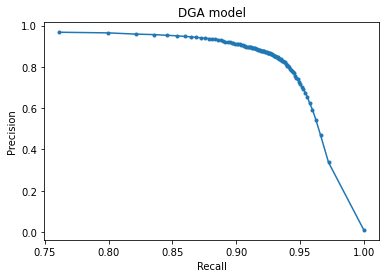

In [ ]:
print("Training binary model...")
model_binary = train_model_binary(X_train, y_train, X_test, y_test)
print("Evaluating binary model...")
model_eval_binary(model_binary, X_test, y_test, domain_test, type_test)

# Training to detect to which of the DGA is belogs

In [ ]:
print("Processing data for families model...")
train_generator, validation_generator, X_data, encoded_labels, steps_per_epoch, domains, labels_type, train_indices_same, train_indices_diff, test_indices_same, test_indices_diff = data_preprocessing_families(df_families)
print("Training families model...")
model_families = train_model_families(train_generator, steps_per_epoch)

Processing data for families model...
nan
nan
nan
nan
Training families model...
Epoch 1/120
165/165 [==============================] - 81s 480ms/step - loss: 0.1201
Epoch 2/120
165/165 [==============================] - 96s 581ms/step - loss: 0.0336
Epoch 3/120
165/165 [==============================] - 80s 482ms/step - loss: 0.0249
Epoch 4/120
165/165 [==============================] - 86s 518ms/step - loss: 0.0190
Epoch 5/120
165/165 [==============================] - 88s 533ms/step - loss: 0.0160
Epoch 6/120
165/165 [==============================] - 84s 513ms/step - loss: 0.0149
Epoch 7/120
165/165 [==============================] - 91s 552ms/step - loss: 0.0117
Epoch 8/120
165/165 [==============================] - 80s 489ms/step - loss: 0.0118
Epoch 9/120
165/165 [==============================] - 83s 503ms/step - loss: 0.0100
Epoch 10/120
165/165 [==============================] - 89s 539ms/step - loss: 0.0078
Epoch 11/120
165/165 [==============================] - 78s 476ms/st

# Evaluation of the families model

In [ ]:
print("Evaluating families model...")
model_eval_families(model_families, train_indices_same, train_indices_diff, test_indices_same, test_indices_diff)

Evaluating families model...



0.9839387566491385



0.05320433044685712


# Conclusions
Here we show an example of detecting character DGA algorithms with high Precision 0.9 and Recall 0.9 and also high accuracy 0.95 of detecting many character DGA families. In future work we can develop also a word-base DGA model. Our model based on AppShield - BlueField which is a agentless system. By using AppShield we succeeded to detect DGA malwares before the malware connects with his command and control server.

# References
https://underdefense.com/guides/detecting-dga-domains-machine-learning-approach/